<H1><center>Predict future sales</center></H1>

翌月のすべての製品と店舗の総売上高を予測していただきます。このコンペを解くことで、あなたのデータサイエンスのスキルを応用し、高めることができます。

あなたには日々の過去の販売データが提供されています。課題は、テストセットのすべてのショップで販売された商品の合計金額を予測することです。ショップと商品のリストは、毎月少しずつ変化していることに注意してください。このような状況に対応できるロバストなモデルを作成することも課題の一つです。

### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category


### Dependencies

In [2]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import catboost
# from catboost import Pool
# from catboost import CatBoostRegressor
# from xgboost import XGBRegressor
# from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

### Loading data

In [5]:
test = pd.read_csv('./input/competitive-data-science-predict-future-sales/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('./input/competitive-data-science-predict-future-sales/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('./input/competitive-data-science-predict-future-sales/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('./input/competitive-data-science-predict-future-sales/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('./input/competitive-data-science-predict-future-sales/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

### Join data sets

In [6]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

### Let's take a look at the raw data

In [7]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [8]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [9]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


### Time period of the dataset

In [10]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


### Data leakages

About data leakages I'll only be using only the "shop_id" and "item_id" that appear on the test set.

データの漏洩について

データリークについて テストセットに現れた「shop_id」と「item_id」のみを使用することにします。

In [11]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [12]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


### Data cleaning

    Only records with "item_price" > 0.

In [13]:
train = train.query('item_price > 0')

### Data preprocessing
* I'm dropping the text features since I won't be doing anything with them.
* We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's remove unwanted columns and aggregate the data by month.

データの前処理

テキストの特徴は何もしないので、削除しておきます。
翌月の各商品、各店舗の総売上高を予測するよう求められていますが、データは日ごとに与えられているので、不要な列を削除して、月ごとにデータを集計してみましょう。

In [14]:
# Select only useful features.
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [15]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

#### データの実際の動作を模倣するために、読み込まれたデータセットから欠落したレコードを作成する必要があります。したがって、各月について、ショップとアイテムごとに欠落したレコードを作成する必要がありますが、それらのデータがないので、0に置き換えます。

In [16]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [17]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

### New dataset

In [18]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.60,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00


In [19]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,6734448.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,6734448.00,11041.89,6210.74,30.00,5385.25,11265.50,16068.25,22167.00
item_category_id,6734448.00,3.79,13.21,0.00,0.00,0.00,0.00,83.00
item_price,6734448.00,187.35,2171.80,0.00,0.00,0.00,0.00,515573.59
mean_item_price,6734448.00,81.13,531.16,0.00,0.00,0.00,0.00,42990.00
item_cnt,6734448.00,0.24,3.46,-4.00,0.00,0.00,0.00,2253.00
mean_item_cnt,6734448.00,0.10,0.61,-2.00,0.00,0.00,0.00,1000.00
transactions,6734448.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00


In [20]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

### EDA

In [21]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

### 売上高は年間でどのように推移するのでしょうか？

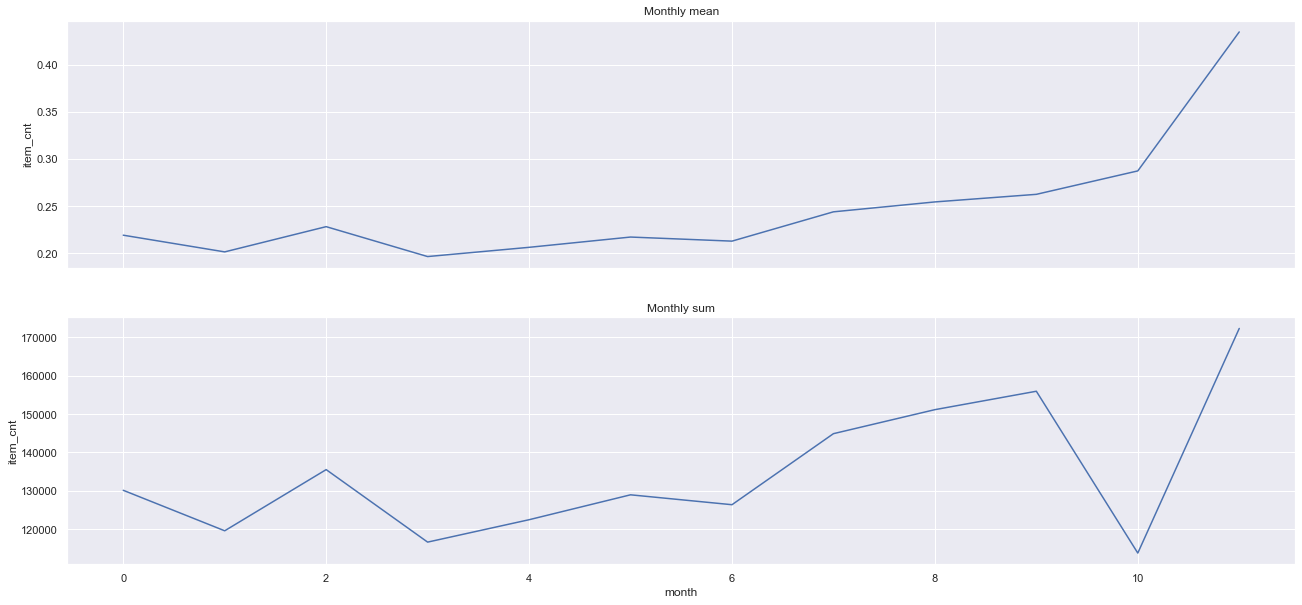

In [22]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

このように、年末に向けてアイテム販売数（平均値）が増加する傾向にあります。

### どのカテゴリーがより売れるのか？

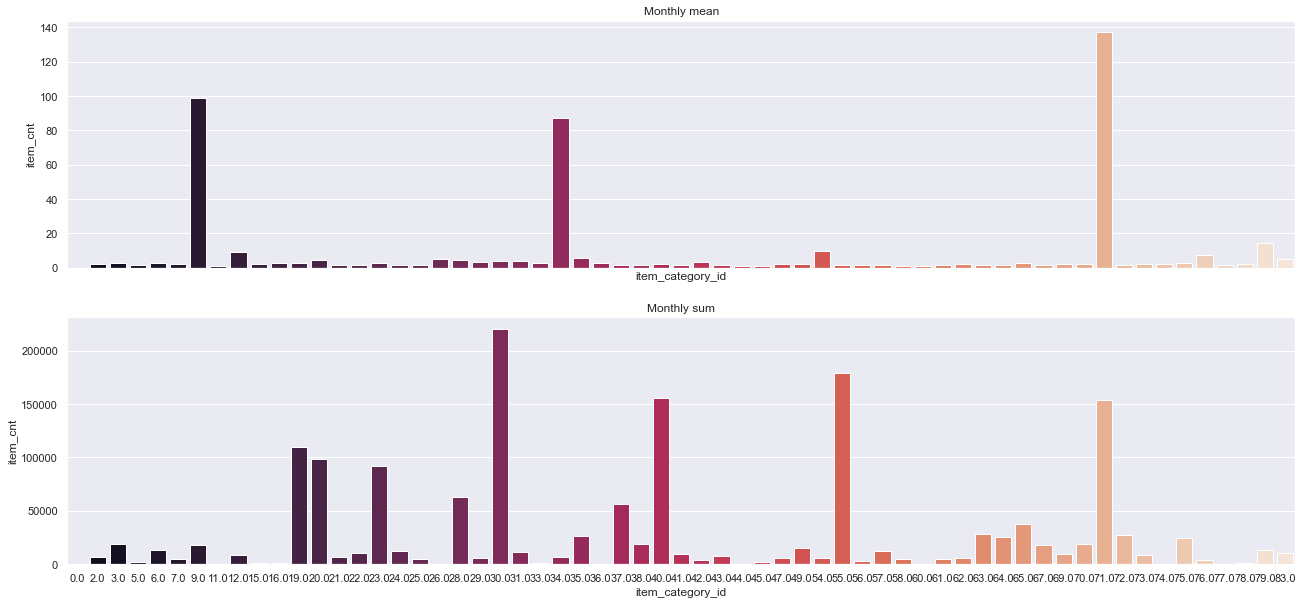

In [23]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

また、いくつかのカテゴリーだけが販売数の大半を占めているようです。

### どの店がより多く売れるか？

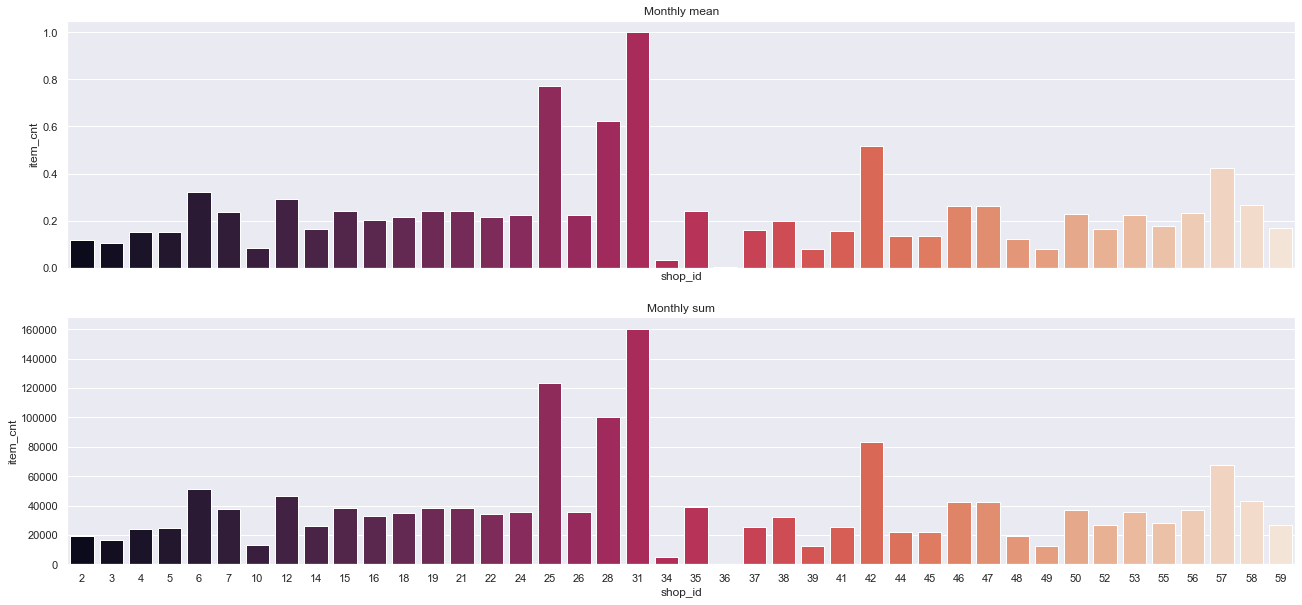

In [24]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

ほとんどのショップの販売率は同じくらいですが、3つのショップの販売率はかなり高く、これはショップの規模を表しているのかもしれません。

### Checking for outliers

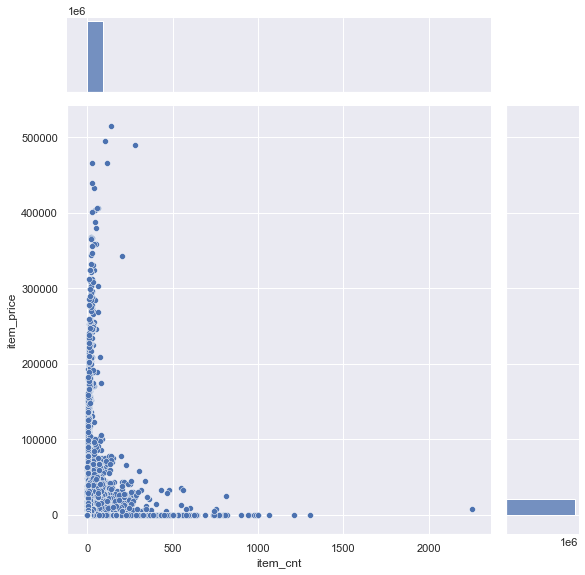

In [25]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

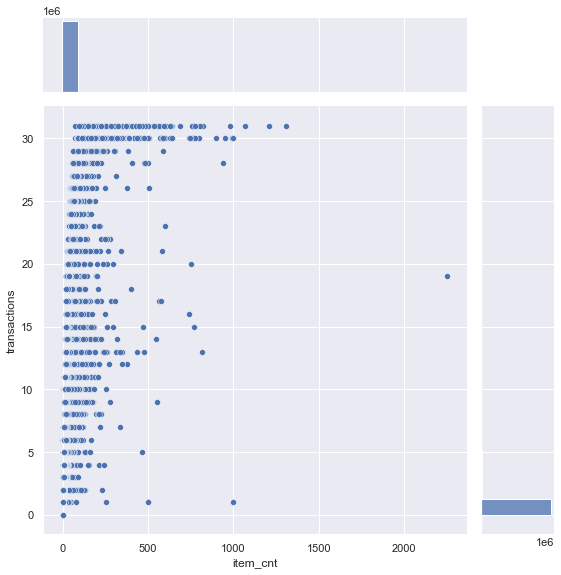

In [26]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

### 特集「item_cnt」の配信。

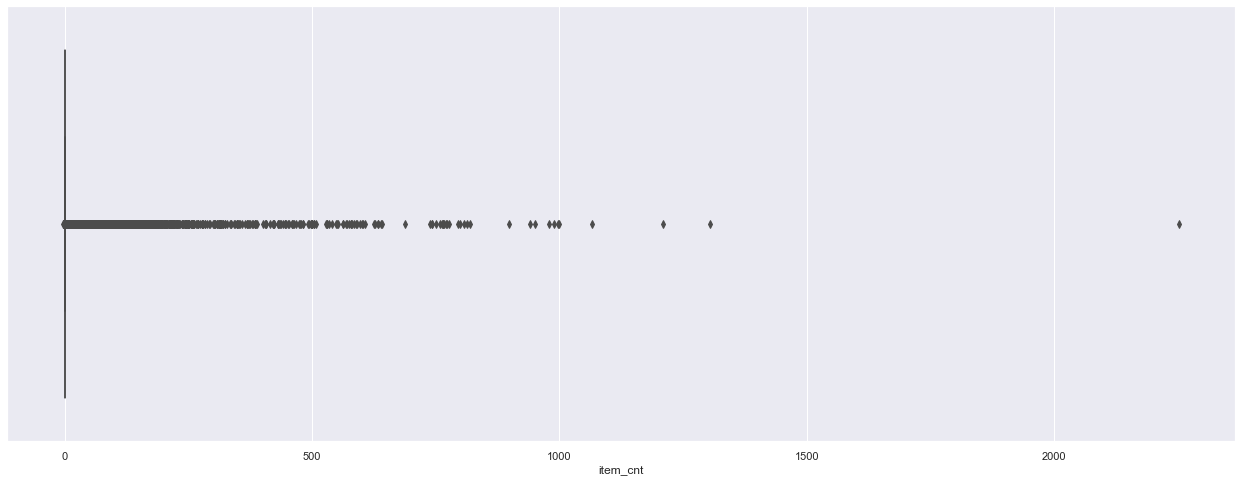

In [27]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

#### 外れ値の除去

item_cnt" > 20 and < 0, "item_price" >= 400000 を外れ値として扱うので、これらを削除してみます。

In [28]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

### ラベルの作成

予測の問題を扱っているので、ラベルは翌月の「item_cnt」とします。

In [29]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)


### Feature engineering

#### 単品価格

In [31]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

#### Group based features.グループベースの機能。

In [32]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

#### How much each item's price changed from its (lowest/highest) historical price.

In [36]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

#### Rolling window based features (window = 3 months).

In [37]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [39]:
train_monthly[train_monthly.item_id == 5572]

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,...,1.00,1192.00,0.00,18979.50,10730.00,8249.50,9.00,9.00,9.00,0.00
4716,0,3,5572,2.00,4770.00,1590.00,3.00,1.00,3.00,2013,...,1.00,1590.00,0.00,18979.50,4770.00,14209.50,3.00,3.00,3.00,0.00
9432,0,4,5572,2.00,4570.00,1523.33,3.00,1.00,3.00,2013,...,4.00,1523.00,0.00,18979.50,4570.00,14409.50,3.00,3.00,3.00,0.00
14147,0,6,5572,2.00,11130.00,1590.00,8.00,1.14,7.00,2013,...,2.00,1391.00,0.00,18979.50,11130.00,7849.50,8.00,8.00,8.00,0.00
18858,0,7,5572,2.00,11030.00,1575.71,8.00,1.14,7.00,2013,...,7.00,1378.00,0.00,18979.50,11030.00,7949.50,8.00,8.00,8.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6704551,33,49,5572,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,NaN,0.00,0.00,18979.50,0.00,18979.50,0.00,0.00,0.00,0.00
6709267,33,39,5572,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,NaN,0.00,0.00,18979.50,0.00,18979.50,0.00,0.00,0.00,0.00
6713977,33,48,5572,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,NaN,0.00,0.00,18979.50,0.00,18979.50,0.00,0.00,0.00,0.00
6718689,33,34,5572,0.00,0.00,0.00,0.00,0.00,0.00,2015,...,NaN,0.00,0.00,18979.50,0.00,18979.50,0.00,0.00,0.00,0.00


#### Lag based features.

In [ ]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

#### Item sales count trend.

In [ ]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

### Dataset after feature engineering

In [ ]:
train_monthly.head().T

In [ ]:
train_monthly.describe().T

### 訓練/検証の分割

テストセットは未来にあることがわかっているので、訓練/検証の分割で同じ分布をシミュレートしてみましょう。
訓練セットは最初の328ブロック、検証セットは最後の5ブロック（2932）、テストセットは33ブロックとします。
最初の3ヶ月は除外しています。これは、特徴量の生成に3ヶ月のウィンドウを使用しているため、最初の3ヶ月は実際にはウィンドウで有用な特徴量を持っていないからです。

In [ ]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

### Mean encoding.
* done after the train/validation split.

In [ ]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [ ]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [ ]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

### Build test set
We want to predict for "date_block_num" 34 so our test set will be block 33 and our predictions should reflect block 34 values. In other words we use block 33 because we want to forecast values for block 34.

In [ ]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

### Replacing missing values.

In [ ]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [ ]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

### Test set

In [ ]:
X_test.head().T

In [ ]:
X_test.describe().T

### Modeling the data

## Tree based models

### Catboost

In [ ]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

In [ ]:
print('Model params:', catboost_model.get_params())

### Catboost feature importance

In [ ]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

### Let's see how catboost performed with this "prediction x label" plot.
The closer the points are to the middle dashed line the better are the predictions.

In [ ]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
# model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
model_performance_sc_plot(catboost_val_pred, Y_validation, 'Validation')

### XGBoost

In [ ]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [ ]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

### XGBoost feature importance

In [ ]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [ ]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

### Let's see how XGBoosting performed with this "prediction x label" plot.

In [ ]:
# model_performance_sc_plot(xgb_train_pred, Y_train, 'Train')
model_performance_sc_plot(xgb_val_pred, Y_validation, 'Validation')

### Random forest

In [ ]:
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [ ]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

In [ ]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

### Let's see how random forest performed with this "prediction x label" plot.

In [ ]:
# model_performance_sc_plot(rf_train_pred, Y_train, 'Train')
model_performance_sc_plot(rf_val_pred, Y_validation, 'Validation')

## Linear models

### Linear Regression

In [ ]:
# Use only part of features on linear Regression.
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

#### Normalizing features

In [ ]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [ ]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

In [ ]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

### Let's see how linear regression performed with this "prediction x label" plot.

In [ ]:
# model_performance_sc_plot(lr_train_pred, Y_train, 'Train')
model_performance_sc_plot(lr_val_pred, Y_validation, 'Validation')

## Clustering models

### KNN Regressor

In [ ]:
# Use only part of features on KNN.
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

#### Normalizing features

In [ ]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

In [ ]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

### Let's see how knn performed with this "prediction x label" plot.

In [ ]:
# model_performance_sc_plot(knn_train_pred, Y_train_sampled, 'Train')
model_performance_sc_plot(knn_val_pred, Y_validation, 'Validation')

### Create new datasets with the predictions from first level models.
* Here I'll be using a simple ensembling technique, I'll use the 1st level models predictions as the input for the 2nd level model, this way the 2nd level model will basically use the 1st level models predictions as features and learn where to give more weight.
* To use this technique I also need to use the 1st level models and make predictions on the test set, so I can use them on the 2nd level model.
* I could also pass the complete validation set with extra features (the 1st level models prediction) to the 2nd level model and let it do a little more work on finding the solution.

In [ ]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

In [ ]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

### Ensembling

* To combine the 1st level model predictions, I'll use a simple linear regression.
* As I'm only feeding the model with predictions I don't need a complex model.

#### Ensemble architecture:
* 1st level:
    * Catboost
    * XGBM
    * Random forest
    * Linear Regression
    * KNN
* 2nd level;
    * Linear Regression
    
#### Here is an  image to help the understanding
 
 <img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Predict%20Future%20Sales/Ensemble%20Kaggle.jpg" width="400">

### 2nd level model as a linear regression
* This is the model that will combine the other ones to hopefully make an overall better prediction.
* If the inputs to this mode were more complex, could be a good idea to split the data into train and validation again, this way you can check if the metal model is overfitting.

In [ ]:
meta_model = LinearRegression(n_jobs=-1)

#### Trained on validation set using the 1st level models predictions as features.

In [ ]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

#### Make predictions on test set using the 1st level models predictions as features.

In [ ]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

#### Ensemble model metrics on validation set.

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

#### Let's see how the meta model performed with this "prediction x label" plot.

In [ ]:
model_performance_sc_plot(ensemble_pred, Y_validation, 'Validation')

#### Output dataframe.

In [ ]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)